##  CutMix 또는 Mixup 비교실험

이번에는 최신 기법(CutMix 또는 Mixup)을 적용해 모델을 훈련시켜 봅시다. 데이터셋에 두 가지 방법 중 하나를 적용하고, 모델을 학습시킨 후 결과를 수치화하고 비교하겠습니다.

In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## 데이터 로드
데이터가 제대로 받아졌는지 확인해 봅시다.

In [3]:
import urllib3
urllib3.disable_warnings()
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

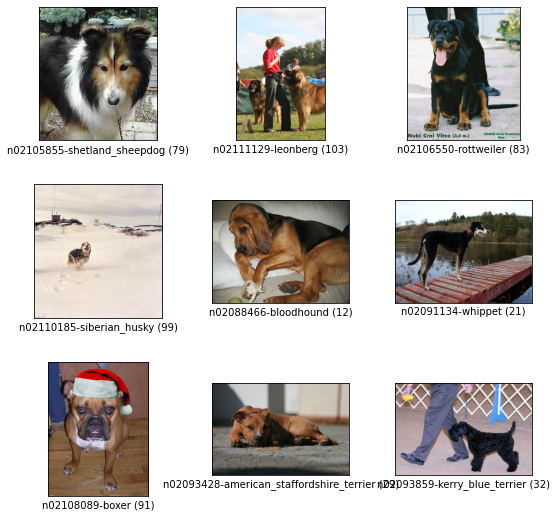

In [4]:
fig = tfds.show_examples(ds_train, ds_info)

### 1. Augmentation을 적용한 데이터셋 만들기
---
이전 스텝과 아래 코드를 참고하여 데이터셋에 CutMix 또는 Mixup augmentation을 적용해 주세요.

**Q1. 아래는 CutMix를 적용할 수 있도록 변경한 apply_normalize_on_dataset()입니다. batch() 함수 뒤에 CutMix가 오도록 만들어야합니다. 그 이유가 뭘까요?**

<br>

**A.**   
CutMix는 배치 안에 있는 이미지끼리만 섞는 과정이기 때문에, 미리 배치 단위로 데이터셋을 정렬 후 CutMix가 적용되어야 합니다.


Augmentation을 적용하기 전에 이미지들을 같은 크기로 만들어 주는 기본적인 전처리 함수를 만들겠습니다.

In [5]:
# 데이터 기본 설정 
INPUT_SHAPE = [200, 200]  # resize 할 이미지 크기
num_classes = 120         # 데이터 셋의 class 개수
batch_size = 32

In [6]:
def normalize_and_resize_img(image, label):
    """Normalizes images: `uint8` -> `float32`."""  
    image = tf.image.resize(image, INPUT_SHAPE) 
    return tf.cast(image, tf.float32) / 255., label # 이미지 크기 및 형식 전처리

위의 이미지 크기 전처리 함수의 입력과 return을 augment 함수의 입력과 return과 동일하게 만든 경우    
이미지 변환의 결과로 리턴받은 이미지를 그 다음 Augmentation 전처리 함수의 입력으로 연거푸 사용할 수 있는 구조가 되어 편리합니다.  이 함수는 입력받은 이미지를 0~1 사이의 float32로 normalize하고, (200, 200) 사이즈로 resize합니다. 이 함수는 훈련용과 테스트용으로 사용될 모든 이미지에 적용될 것입니다.

``` python
def augment(image, label):   # 변환된 이미지와 라벨
    # 이미지 Agumentation 적용
    new_image = 이미지_agumentation(image)    
    return new_image, label
```    

- resize 전처리 함수와 augment 함수의 구조를 동일하게 만들어 사용하기 편리하게 만들어 줍니다.


In [7]:
def augment(image,label):
    image = tf.image.random_flip_left_right(image)  # 50% 확률로 좌우 반전
    image = tf.image.random_brightness(image, max_delta=0.3)  # 0.3 까지 랜덤 밝기 
    image = tf.image.central_crop(image, np.random.uniform(0.80, 1.00)) # 중앙을 기준으로 80~100의 비율로 잘라 줍니다.
    image = tf.image.resize(image, INPUT_SHAPE) # crop한 이미지를 원본 사이즈로 resize
    return image,label



Augmentation을 통해 원본 데이터셋에 다양한 형태의 가공한 형태의 새로운 데이터셋을 얻게 되는 모든 과정을 구현한 메인 함수를 **apply_normalize_on_dataset()**로 정의하겠습니다.  

**apply_normalize_on_dataset()**를 통해서 일반적인 전처리 과정, 즉 normalize, resize, augmentation과 shuffle을 적용하도록 하겠습니다. 이때 주의해야할 점은 shuffle이나 augmentation은 테스트 데이터셋에는 적용하지 않아야 합니다.  


이후에 수행할 비교실험을 위해서 **with_aug** 매개변수를 통해 augmentation의 적용여부를 결정, 
**with_cutmix** 매개변수를 이용해 cutmix 적용 여부를 결정하게 만들겠습니다.

In [8]:
def onehot(image, label, batch_size=32, img_size = 200, num_classes =120): 

    label = tf.one_hot(label, num_classes)
    return image, label

In [9]:
# 데이터셋 전처리 함수
def apply_normalize_on_dataset(ds, is_test=False, batch_size=32, with_aug=False, with_cutmix=False, with_mixup = False):
    ds = ds.map(
        normalize_and_resize_img,    # 기본적인 전처리 함수 적용 [image_resige]
        num_parallel_calls=2
    )
    if not is_test and with_aug:    #  train일때 augmentation 적용 여부 결정  
        ds = ds.map(
            augment
        )
    ds = ds.batch(batch_size)   # batch 단위로 데이터셋 정렬
    if not is_test and with_cutmix:  # batch 안에 있는 이미지끼리만 섞는 과정
        ds = ds.map(
            cutmix,                # cutmix 적용
            num_parallel_calls=2
        )
        # mixup와 cutmix를 같이 적용하지 않을 것이니 elif로 한다.
    elif not is_test and with_mixup:  # batch 안에 있는 이미지끼리만 섞는 과정
        ds = ds.map(
            mixup,                # mixup 적용
            num_parallel_calls=2
        )
    else  :  
        ds = ds.map(
            onehot,
            num_parallel_calls=2
        )

    if not is_test:             # test가 아닌 경우에만 shuffle, repear 적용
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

텐서플로우 데이터셋에서 불러온 데이터에 하나는 **apply_normalize_on_dataset()**에서 **with_aug**를 **False** 로augmentation이 적용되지 않도록 하고, 다른 하나는 **True**로 주어 augmentation이 적용되도록 합니다.

**with_cutmix**와 **with_mixup**도 동일하게  True, False 옵션을 주겠습니다.

In [10]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)

In [11]:
ds_train_no_aug = apply_normalize_on_dataset(
    ds_train, batch_size, with_aug=False
)  # aug x , cutmix x, mixuo x

ds_train_aug = apply_normalize_on_dataset(
    ds_train, batch_size, with_aug=True
)     # aug O , cutmix x, mixup x

## CutMix Augmentation

위에 데이터셋에 관한 전처리 함수들의 생성이 완료되었으니 cutmix를 할 함수를 생성하겠습니다.

### Mix image

가장 먼저 두 개의 이미지를 섞어주는 것부터 생각해 봅시다. 배치 내의 이미지를 두 개 골라서 섞어줍니다. 이때 이미지에서 잘라서 섞어주는 영역을 바운딩 박스(bounding box)라고 부릅니다.

두 개의 이미지 a, b 모두 (200, 200)로 resize되어 두 이미지의 width, height가 같은 경우로 가정할 수 있지만, CutMix 공식 repo 에서는 width, height가 다르더라도 가변적으로 적용할 수 있도록 구현되어 있기 때문에, 임의의 이미지 사이즈에 대해서도 유연하게 대응 가능하도록 구현해 보겠습니다.


예시를 위해 훈련데이터셋에서 이미지 2개를 가져와 보겠습니다.

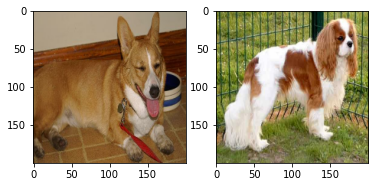

In [11]:
import matplotlib.pyplot as plt

# 데이터셋에서 이미지 2개를 가져옵니다. 
for i, (image, label) in enumerate(ds_train_no_aug.take(1)):
    if i == 0:
        image_a = image[0]
        image_b = image[1]
        label_a = label[0]
        label_b = label[1]
        break

plt.subplot(1,2,1)
plt.imshow(image_a)

plt.subplot(1,2,2)
plt.imshow(image_b)

In [12]:
def get_clip_box(image_a, image_b):
    # image.shape = (height, width, channel)
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0]
    
    # get center of box
    x = tf.cast( tf.random.uniform([],0, image_size_x),tf.int32)
    y = tf.cast( tf.random.uniform([],0, image_size_y),tf.int32)

    # get width, height of box
    # width, height 임의의 영역을 가지고 옵니다. 
    width = tf.cast(image_size_x * tf.math.sqrt(1-tf.random.uniform([],0,1)),tf.int32)   
    height = tf.cast(image_size_y * tf.math.sqrt(1-tf.random.uniform([],0,1)),tf.int32)
    
    # clip box in image and get minmax bbox
    # //2를 해주는 이유는 x보다 width가 더 커질 수 있기에 범위를 줄이고자 사용합니다.
    xa = tf.math.maximum(0, x-width//2)
    ya = tf.math.maximum(0, y-height//2)
    xb = tf.math.minimum(image_size_x, x+width//2)
    yb = tf.math.minimum(image_size_y, y+width//2)
    
    return xa, ya, xb, yb

In [13]:
xa, ya, xb, yb = get_clip_box(image_a, image_b)   # bounding box 범위
print(xa, ya, xb, yb)

tf.Tensor(66, shape=(), dtype=int32) tf.Tensor(55, shape=(), dtype=int32) tf.Tensor(200, shape=(), dtype=int32) tf.Tensor(175, shape=(), dtype=int32)


바탕이미지 a에서 바운딩 박스 바깥쪽 영역을, 다른 이미지 b에서 바운딩 박스 안쪽 영역을 가져와서 합치는 함수를 구현해 봅시다.   

2개의 image와 boundding box를  parameter로 받으면 2 이미지를 mix하는 함수를 구현합니다.

In [13]:
# mix two images
def mix_2_images(image_a, image_b, xa, ya, xb, yb):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    one = image_a[ya:yb,0:xa,:]
    two = image_b[ya:yb,xa:xb,:]
    three = image_a[ya:yb,xb:image_size_x,:]
    middle = tf.concat([one,two,three],axis=1)
    top = image_a[0:ya,:,:]
    bottom = image_a[yb:image_size_y,:,:]
    mixed_img = tf.concat([top, middle, bottom],axis=0)
    
    return mixed_img

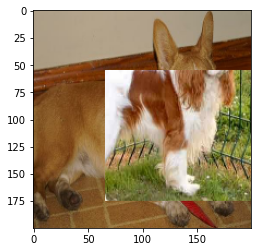

In [15]:
mixed_img = mix_2_images(image_a, image_b, xa, ya, xb, yb)
plt.imshow(mixed_img.numpy())

###  Mix label
---
이미지를 섞었다면 라벨도 이에 맞게 섞어주어야 합니다. 그림에서 볼 수 있듯, 우리가 강아지와 고양이의 이미지를 섞었다면 라벨 또한 적절한 비율로 섞여야 합니다.

**CutMix**에서는 면적에 비례해서 라벨을 섞어줍니다. 섞인 이미지의 전체 이미지 대비 비율을 계산해서 두 가지 라벨의 비율로 더해줍니다. 예를 들어 A 클래스를 가진 원래 이미지 **image_a**와 B 클래스를 가진 이미지 **image_b**를 섞을 때 **image_a**를 0.6만큼 섞었을 경우, 0.6만큼의 클래스 A, 0.4만큼의 클래스 B를 가지도록 해줍니다. 이때 라벨 벡터는 보통 클래스를 표시하듯 클래스 1개만 1의 값을 가지는 원-핫 인코딩이 아니라 A와 B 클래스에 해당하는 인덱스에 각각 0.6, 0.4을 배분하는 방식을 사용합니다.

위에서 섞인 이미지 두 가지에 대하여 라벨을 만들 때 적절한 비율로 라벨을 합쳐주는 함수를 구현해 봅시다.

In [14]:
# mix two labels
def mix_2_label(label_a, label_b, xa, ya, xb, yb, imag_size=200 ,num_classes=120):
#    image_size_x = image_a.shape[1]
#    image_size_y = image_a.shape[0] 
    mixed_area = (xb-xa)*(yb-ya)
    total_area = imag_size **2
    a = tf.cast(mixed_area/total_area, tf.float32)

    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_label = (1-a)*label_a + a*label_b
    return mixed_label

In [17]:
mixed_label = mix_2_label(label_a, label_b, xa, ya, xb, yb)
mixed_label

<tf.Tensor: shape=(120,), dtype=float32, numpy=
array([0.   , 0.   , 0.   , 0.   , 0.   , 0.402, 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.598, 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   ], dtype=float32

위에서 구현한 두 함수 **`mix_2_images()`**와 **`mix_2_label()을`** 활용하여 배치 단위의 **cutmix()** 함수를 구현해 봅시다.

In [15]:
def cutmix(image, label, prob = 1.0, batch_size=32, img_size=200, num_classes=120):
    mixed_imgs = []
    mixed_labels = []
    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0, batch_size),tf.int32)
        while i ==j:                                                     # i와 j가 같은 경우 
            j = tf.cast(tf.random.uniform([],0, batch_size),tf.int32)    # 같은 이미지로 cutmix 될 수 있으니 다른 값을 가지게 만든다.
        image_b = image[j]
        label_b = label[j]
        xa, ya, xb, yb = get_clip_box(image_a, image_b)
        mixed_imgs.append(mix_2_images(image_a, image_b, xa, ya, xb, yb))
        mixed_labels.append(mix_2_label(label_a, label_b, xa, ya, xb, yb))

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs),(batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels),(batch_size, num_classes))
    return mixed_imgs, mixed_labels

## Mixup Augmentation

**Mixup**은 위에서 보여드린 CutMix보다 간단하게 이미지와 라벨을 섞어줍니다.  
**Mixup**은 두 개 이미지의 픽셀별 값을 비율에 따라 섞어주는 방식으로 CutMix보다 구현이 간단합니다.  



In [16]:
# function for mixup
def mixup_2_images(image_a, image_b, label_a, label_b):
    a = tf.random.uniform([],0,1)
    
    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_image= (1-a)*image_a + a*image_b
    mixed_label = (1-a)*label_a + a*label_b
    
    return mixed_image, mixed_label

tf.Tensor(
[0.    0.    0.    0.    0.    0.402 0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.598 0.    0.    0.    0.    0.    0.    0.    0.   ], shape=(120,), dtype=float32)


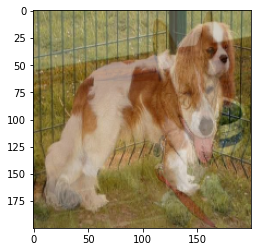

In [20]:
mixed_img, _ = mixup_2_images(image_a, image_b, label_a, label_b)
plt.imshow(mixed_img.numpy())
print(mixed_label)

그러면 위에서 구현한 함수를 활용하여 배치 단위의 mixup() 함수를 구현해 봅시다.

In [17]:
def mixup(image, label, prob = 1.0, batch_size=32, img_size=200, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):   # batch_size 단위로 image mixup이 진행됩니다.
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0, batch_size),tf.int32)  # [0, batch]  0부터 batch 까지의 임의 숫자
        while i == j :  # 임의의 숫자를 생성하는데 만약 같은 라벨이 불려지는 경우 
            j = tf.cast(tf.random.uniform([],0, batch_size),tf.int32)  # 재 생성 해준다.
        image_b = image[j]
        label_b = label[j]
        mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b)  # mixup_image 함수
        mixed_imgs.append(mixed_img)
        mixed_labels.append(mixed_label)

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs),(batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels),(batch_size, num_classes))
    return mixed_imgs, mixed_labels

함수를 보면 **Cutmix**보다 **mixup**이 더 간단하게 구현을 할 수 있는것을 알 수 있습니다.

In [21]:
ds_train_cutmix = apply_normalize_on_dataset(ds_train, batch_size = batch_size, with_cutmix=True)     # aug O , cutmix 0, mixup x
ds_train_mixup = apply_normalize_on_dataset(ds_train, batch_size, with_mixup=True)     # aug O , cutmix x, mixup 0

ds_test = apply_normalize_on_dataset(ds_test, batch_size=batch_size, is_test = True)

### 2. 모델 만들기
---
앞서 만들었던 것처럼 비교실험을 위한 모델 두 개를 만들어 주세요. 모델은 ResNet-50을 사용합시다.

텐서플로우 케라스의 **ResNet50** 중 **imagenet**에 훈련된 모델을 불러옵니다. **include_top**은 마지막 fully connected layer를 포함할지 여부입니다. 해당 레이어를 포함하지 않고 생성하면 특성 추출기(feature extractor) 부분만 불러와 우리의 필요에 맞게 수정된 fully connected layer를 붙여서 활용할 수 있습니다. 이렇게 하는 이유는 이미지넷(ImageNet)과 우리의 테스트셋이 서로 다른 클래스를 가지므로, 마지막에 추가해야 하는 fully connected layer의 구조(뉴런의 개수) 또한 다르기 때문입니다.

In [22]:
num_classes = ds_info.features["label"].num_classes
resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(200, 200,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation = 'softmax')
])

Augmentation을 적용한 데이터셋으로 학습시킬 ResNet을 하나 더 만들어줍니다.

In [23]:
aug_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(200, 200,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation = 'softmax')
])

추가로 cut_mix, mixup을 적용한 데이터셋으로 학습시킬 ResNet을 만들어 줍니다.

In [25]:
# cutmix ResNet
cutmix_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(200, 200,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation = 'softmax')
])

In [26]:
# mixup ResNet
mixup_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(200, 200,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation = 'softmax')
])

텐서플로우 데이터셋에서 불러온 데이터에 하나는 **apply_normalize_on_dataset()**에서 **with_aug**를 **False**로 주어 augmentation이 적용되지 않도록 하고, 다른 하나는 **True**로 주어 augmentation이 적용되도록 합니다.

그리고 aug를 적용한 cutmix, mixup를 활용해 어떤 Agumentation이 가장 좋은 결과인지 확인해 봅시다.

train할 데이터 셋이 모두 준비가 되었네요

### 3. 모델 훈련하기
---
모델을 훈련시켜 주세요.

힌트: 위에서 만든 CutMix나 Mixup을 사용하기 위해서는 앞에서 **`resnet50`**과 **`aug_resnet50`**을 훈련하는 데 사용했던 **`sparse_categorical_crossentropy()`** 대신 **`categorical_crossentropy()`**를 사용해주세요!





**Q3. sparse_categorical_crossentropy()를 사용하지 못하는 이유가 뭘까요?**

<br>

**A.**   

우리가 cutmix(), mixup()을 구현하면서 label의 mix 때문에 더이상 label이 스칼라값을 가지지 못하고 One-Hot 벡터 형태로 변환되었기 때문

In [24]:
#EPOCH = 20  # Augentation 적용 효과를 확인하기 위해 필요한 epoch 수
EPOCH = 20

tf.random.set_seed(200)
resnet50.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

aug_resnet50.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

history_resnet50_no_aug = resnet50.fit(
    ds_train_no_aug, # augmentation 적용하지 않은 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/batch_size),
    validation_steps=int(ds_info.splits['test'].num_examples/batch_size),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

history_resnet50_aug = aug_resnet50.fit(
    ds_train_aug, # augmentation 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/batch_size),
    validation_steps=int(ds_info.splits['test'].num_examples/batch_size),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
375/375 [==============================] - 87s 232ms/step - loss: 2.6808 - accuracy: 0.3766 - val_loss: 4.9717 - val_accuracy: 0.0084
Epoch 2/20
375/375 [==============================] - 87s 232ms/step - loss: 0.9741 - accuracy: 0.7398 - val_loss: 3.4992 - val_accuracy: 0.1867
Epoch 3/20
375/375 [==============================] - 88s 234ms/step - loss: 0.4308 - accuracy: 0.9065 - val_loss: 1.2361 - val_accuracy: 0.6413
Epoch 4/20
375/375 [==============================] - 87s 233ms/step - loss: 0.2085 - accuracy: 0.9674 - val_loss: 1.1511 - val_accuracy: 0.6659
Epoch 5/20
375/375 [==============================] - 87s 233ms/step - loss: 0.0877 - accuracy: 0.9938 - val_loss: 1.0852 - val_accuracy: 0.6824
Epoch 6/20
375/375 [==============================] - 87s 233ms/step - loss: 0.0636 - accuracy: 0.9962 - val_loss: 1.0860 - val_accuracy: 0.6848
Epoch 7/20
375/375 [==============================] - 87s 233ms/step - loss: 0.0355 - accuracy: 0.9983 - val_loss: 1.0683 - val_ac

---

위에가 일반 augementation을 적용한 것과 적용하지 않은것   
아래가 cutmix, mixup를 차례로 적용한 모델입니다.

In [27]:
# cutmix 와 mixup도 EPOCH 10으로 하면 시간이 오래 걸리니 EPOCH 10 정도만 하고 어떻게 나올지 살펴봅시다.
EPOCH = 20
tf.random.set_seed(200)
cutmix_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

mixup_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

history_resnet50_cutmix = cutmix_resnet50.fit(
    ds_train_cutmix, # augmentation 적용하지 않은 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/batch_size),
    validation_steps=int(ds_info.splits['test'].num_examples/batch_size),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

history_resnet50_mixup = mixup_resnet50.fit(
    ds_train_mixup, # augmentation 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/batch_size),
    validation_steps=int(ds_info.splits['test'].num_examples/batch_size),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
375/375 [==============================] - 88s 235ms/step - loss: 4.2196 - accuracy: 0.1408 - val_loss: 5.1192 - val_accuracy: 0.0069
Epoch 2/20
375/375 [==============================] - 88s 235ms/step - loss: 3.2602 - accuracy: 0.3624 - val_loss: 3.2906 - val_accuracy: 0.2178
Epoch 3/20
375/375 [==============================] - 88s 236ms/step - loss: 2.9446 - accuracy: 0.4460 - val_loss: 1.4762 - val_accuracy: 0.6019
Epoch 4/20
375/375 [==============================] - 88s 234ms/step - loss: 2.7477 - accuracy: 0.5092 - val_loss: 1.4027 - val_accuracy: 0.6346
Epoch 5/20
375/375 [==============================] - 88s 234ms/step - loss: 2.5838 - accuracy: 0.5573 - val_loss: 1.2613 - val_accuracy: 0.6465
Epoch 6/20
375/375 [==============================] - 88s 234ms/step - loss: 2.4689 - accuracy: 0.5975 - val_loss: 1.2071 - val_accuracy: 0.6723
Epoch 7/20
375/375 [==============================] - 88s 234ms/step - loss: 2.3491 - accuracy: 0.6390 - val_loss: 1.3140 - val_ac

훈련 과정을 시각화 해봅시다.

### model history save
- 메모리 초과가 발생할 수 있으니 안전하게 모델의 history를 저장해서 결과를 시각화하겠습니다.

In [28]:
import pickle

In [35]:
import pickle

with open('./model_save/history_resnet50_cutmix', mode='wb') as file_pi:
    pickle.dump(history_resnet50_cutmix.history, file_pi)

In [37]:
with open('./model_save/history_resnet50_mixup', mode='wb') as file_pi2:
    pickle.dump(history_resnet50_mixup.history, file_pi2)

In [38]:
with open('./model_save/history_resnet50_aug', mode='wb') as file_pi3:
    pickle.dump(history_resnet50_aug.history, file_pi2)

In [40]:
with open('./model_save/history_resnet50_no_aug', mode='wb') as file_pi4:
    pickle.dump(history_resnet50_no_aug.history, file_pi4)

In [ ]:
history_resnet50_no_aug = pickle.load(open('./model_save/history_resnet50_cutmix', "rb"))

In [ ]:
history_resnet50_aug = pickle.load(open('./model_save/history_resnet50_cutmix', "rb"))

In [29]:
history_resnet50_cutmix = pickle.load(open('./model_save/history_resnet50_cutmix', "rb"))

In [30]:
history_resnet50_mixup= pickle.load(open('./model_save/history_resnet50_mixup', "rb"))

## 4. 훈련 과정 시각화하기
---
훈련 과정의 히스토리를 그래프로 시각화해 주세요.



###  no_augment V.S augement
- 두 결과 그래프가 상당히 흡사해서 일정 부분만 잘라서 다시 확인해보겠습니다.

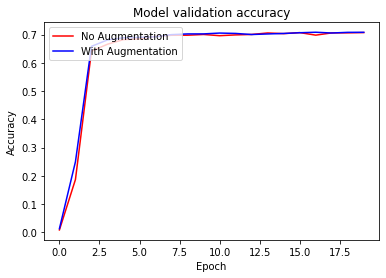

In [25]:
plt.plot(history_resnet50_no_aug.history['val_accuracy'], 'r')
plt.plot(history_resnet50_aug.history['val_accuracy'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation'], loc='upper left')
plt.show()

ylim의 범위를 **`0.6 ~ 0.75`**로 지정해서 결과를 살펴보니 **augment**가 **no augement** 보다 조금 더 위에 있는것 같습니다.  
그리고 20 EPOCH로 많은 학습량은 아니지만, Augement의 그래프가 좀 더 부드러운 모습이고 No Augment는 Augment보다 삐죽한 덜 안정적인 그래프의 모습이 보입니다.  

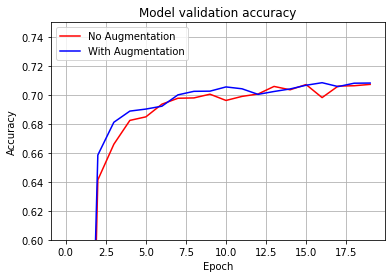

In [53]:
plt.plot(history_resnet50_no_aug.history['val_accuracy'], 'r')
plt.plot(history_resnet50_aug.history['val_accuracy'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation'], loc='upper left')
plt.grid(True)
plt.ylim(0.60, 0.75)
plt.show()

위의 결과를 통해서 No Augment 보다는 Augment를 사용하는게 더 안정적으로 결과에 수렵이 되는것 같습니다.

###  CutMix V.S Mixup
- 육안으로 봤을땐 Mixup Aug가 CutMix보다 더 좋은 결과를 보이고 있습니다.

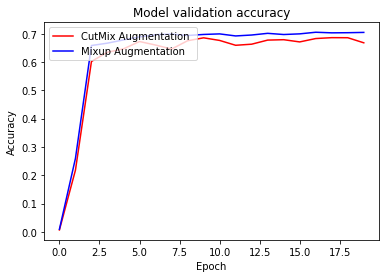

In [28]:
plt.plot(history_resnet50_cutmix.history['val_accuracy'], 'r')
plt.plot(history_resnet50_mixup.history['val_accuracy'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['CutMix Augmentation ', 'Mixup Augmentation '], loc='upper left')
plt.show()

조금 더 확대해 살펴봅시다.

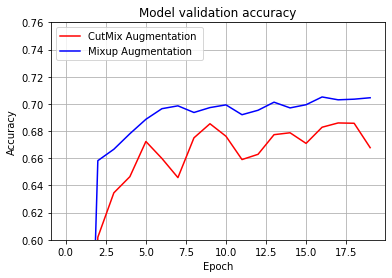

In [31]:
plt.plot(history_resnet50_cutmix.history['val_accuracy'], 'r')
plt.plot(history_resnet50_mixup.history['val_accuracy'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['CutMix Augmentation ', 'Mixup Augmentation '], loc='upper left')
plt.grid(True)
plt.ylim(0.60, 0.76)
plt.show()

**CutMix**를 사용한 모델의 경우 덜 안정적으로 학습이 되어서 삐죽한 모습이 보입니다.   
**Mixup**은 그와는 반대로 그래프가 부드러운 모습을 보이고 상대적으로 안정적이게 학습이 되고 있습니다.

- 지금의 결과만 봤을때 **`[ Mixup > CutMix ]`**의 결과로 보입니다.

### No Augmentation, 기본 Augmentation, 기본 + CutMix 적용, 기본 + Mixup 적용

CutMix를 제외하곤 결과가 상당히 흡사하므로 확대해서 살펴보겠습니다.

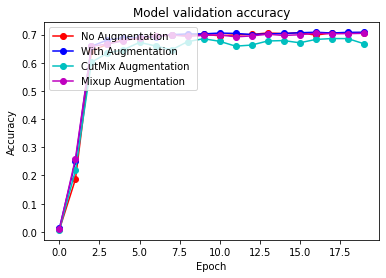

In [52]:
plt.plot(history_resnet50_no_aug.history['val_accuracy'], 'ro-')
plt.plot(history_resnet50_aug.history['val_accuracy'], 'bo-')
plt.plot(history_resnet50_cutmix['val_accuracy'], 'co-')
plt.plot(history_resnet50_mixup['val_accuracy'], 'mo-')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation','CutMix Augmentation ', 'Mixup Augmentation '], loc='upper left')

plt.show()

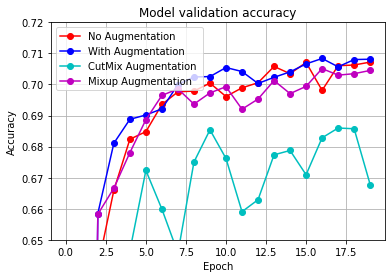

In [57]:
plt.plot(history_resnet50_no_aug.history['val_accuracy'], 'ro-')
plt.plot(history_resnet50_aug.history['val_accuracy'], 'bo-')
plt.plot(history_resnet50_cutmix['val_accuracy'], 'co-')
plt.plot(history_resnet50_mixup['val_accuracy'], 'mo-')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation','CutMix Augmentation ', 'Mixup Augmentation '], loc='upper left')
plt.grid(True)
plt.ylim(0.65, 0.72)
plt.show()

확대해서 살펴본 결과 **CutMix**는 다른 3개의 모델과 비교해 봤을때 덜 안정적이게 학습이 되는것 같습니다.  
그리고 EPOCH 20를 기준으로 나머지 3개의 Augment 기법의 그래프들이 서로 흡사하지만, 결과만 봤을때는 **Augment**만 사용한 결과가 가장 좋았다고 나타났습니다.

### 5. Augmentation에 의한 모델 성능 비교
---
No Augmentation, 기본 Augmentation, 기본 + CutMix 적용, 기본 + Mixup 적용 이상 4가지 경우의 데이터셋에 대해 훈련된 ResNet50 분류기의 견종 분류 정확도 성능을 비교해 보고, Augmentation 방법들의 영향도에 대해 분석해 보세요.

위에서 Augment의 결과가 제일 좋았지만, 이 경우는 EPOCH가 20으로 적은 수의 학습량으로 나타난 결과여서 그런것 같습니다.  
오히려 EPOCH 20을 돌렸는데 학습이 덜 된 CutMix가 EPOCH 100, 300까지 갔을때는 더 좋은 결과가 나타날 수도 있을것 같네요.  
추가로, Mixup 그래프의 경우에도 성능이 더 안좋은 것이 아닌 학습량이 더 많이 필요한것 같습니다.  
EPOCH가 20이 아닌 100,300,500의 경우로 테스트를 하고 싶지만, 20을 돌리는데에만 1시간 반정도 걸려서 아무래도 100, 300까지의 테스트는 물리적으로 힘들것 같습니다.  

우선 나타난 결과를 보고 왜 이런 결과가 나왔는지 생각해 보겠습니다.
우선 CutMix의 경우 데이터셋의 몇몇의 강아지 이미지가 배경에 비해서 상당히 작은 이미지도 있던것 같습니다.  CutMix를 할 때 2 이미지 모두 강아지의 일부분이 배경쪽에 합쳐진게 베스트 이지만, 강아지 보다 배경이 더 많은 부분을 bounding box로 잡고 다른 강아지의 많은 부분을 가린 경우가 있어서 모델이 제대로 학습을 못하고 있는것 같습니다.

**"위에서 말한 CutMix의 결과가 왜 안좋게 나왔을까?"**를 
제가 생각했을때 아래와 같이 데이터 셋에서 발생하는 문제로 인해 CutMix가 제대로 학습이 잘안되는 문제 같습니다.

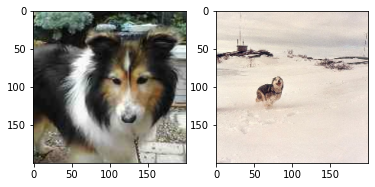

In [59]:
# 왼쪽의 원본 이미지의 경우 강아지임을 알 수 있는 다양한 feature가 많이 나타나 있습니다.
# 오른쪽의 이미지는 배경에 비해 강아지 이미지가 상당히 작기에 문제가 생길 수 있을것 같습니다.
plt.subplot(1,2,1)
plt.imshow(image_a)

plt.subplot(1,2,2)
plt.imshow(image_b)

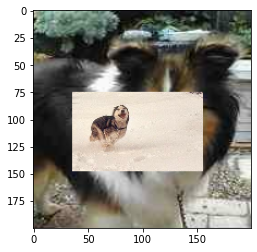

In [62]:
# CutMix를 하니 괜찮았던 강아지 이미지도 모델이 인식하기 헷갈리게 만들어 졌네요
mixed_img = mix_2_images(image_a, image_b, xa, ya, xb, yb)
plt.imshow(mixed_img.numpy())

위와 같은 경우로 인해 CutMix가 다른 3개의 기법 보다 안좋은 결과가 나온것 같습니다.

Mixup의 경우 CutMix에 비하면 두 이미지의 특징들이 보이니 CutMix 보다 더 나은 결과가 나온것 같습니다.

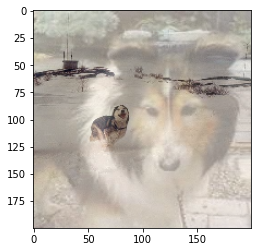

In [63]:
mixed_img, _ = mixup_2_images(image_a, image_b, label_a, label_b)
plt.imshow(mixed_img.numpy())

---


## 회고

- Augementation이 cs231n에서 나왔을때 CutMix와 MixUp라는 방법이 있다고 언급을 했고 좋은 방법이라고 얘기한 것 같은데 실제로 해보니 이런식으로 데이터를 가공하면 더 좋은 성능이 나올것 같다고 생각합니다.   
물론 이러한 Augmentation을 원본 데이터에 비해 너무 많이 적용하면 오히려 성능이 잘 안나올것 같지만, 데이터셋만 많다면 충분히 해볼만한 Augementation 기법이고 상당히 실용적인 방식들이라고 보입니다.  


- 그리고 MixUp보다 CutMIx가 더 좋은 성능을 보인다고 알고 있었는데 직접 해보니 생각보다 잘 안나와서 왜 안나왔는지에 대해 생각을 해봤습니다. 다른 사람들의 **`CutMix vs MixUp`**도 잠깐 살펴봤었는데 보니까 분류하고자 하는 클래스에 해당하는 실제 이미지 부분이 많이 차지한 것 같습니다.  
논문에서 나오는 고양이와 개의 분류에서 고양이와 개 모두 CutMix 이미지에 배경보다 많은 부분을 차지했고 어떤 분이 캐글에 성능 비교 노트북을 올린 (**[참조](https://www.kaggle.com/saife245/cutmix-vs-mixup-vs-gridmask-vs-cutout)**) 분이 사용하신 이미지를 보면 배경보다 꽃 이미지가 확실히 보이는것을 알 수 있습니다.    
<br> 그렇게 좋은 결과가 나왔던 데이터를 보고 위의 제가 사용한 데이터의 CutMix를 보면 배경이 많은 비율을 차지한 것을 알 수 있습니다.  그리고 이미지에 있는 개의 크기를 봤을때도 크기 차이가 많이 발생한 것을 알 수 있습니다.  

- 위의 이유를 통해 CutMix가 MixUp 보다 더 좋은 성능을 보이지만 사용하는 데이터가 배경이 많은 부분을 차지하면 오히려 MixUp 기법이 더 좋은 결과를 보일 수 있다고 생각이 드네요.  
Epoch가 20으로 적어서 결과가 좀 더 뚜렷하게 나타나지 않았을 수 있지만, 위의 결과만 놓고 봤을때는 무조건 **`CutMix > MixUp`**이 아니라 데이터에 따라 **`CutMix =< MixUp`**  이렇게도 될 수 있다고 생각이 됩니다.